In [1]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")


# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)

    N_c = sum(ranked["target_class"] <= 1)
    N_t = sum(ranked["target_class"] >= 2)

    # посчитаем в отсортированном датафрейме основные показатели,
    # которые используются при расчёте Qini Score
    ranked["n_c1"] = 0
    ranked["n_t1"] = 0
    ranked.loc[ranked.target_class == 1, "n_c1"] = 1
    ranked.loc[ranked.target_class == 3, "n_t1"] = 1
    ranked["n_c1/nc"] = ranked.n_c1.cumsum() / N_c
    ranked["n_t1/nt"] = ranked.n_t1.cumsum() / N_t

    # посчитаем Qini-кривую и случайную прямую под ней
    ranked["uplift"] = round(ranked["n_t1/nt"] - ranked["n_c1/nc"], 5)
    # добавим случайную кривую
    ranked["random_uplift"] = round(
        ranked["uplift_score"].rank(pct=True, ascending=False)
        * ranked["uplift"].iloc[-1],
        5,
    )

    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked["n"], ranked["uplift"], color="r")
    plt.plot(ranked["n"], ranked["random_uplift"], color="b")
    plt.show()

    return (ranked["uplift"] - ranked["random_uplift"]).sum()

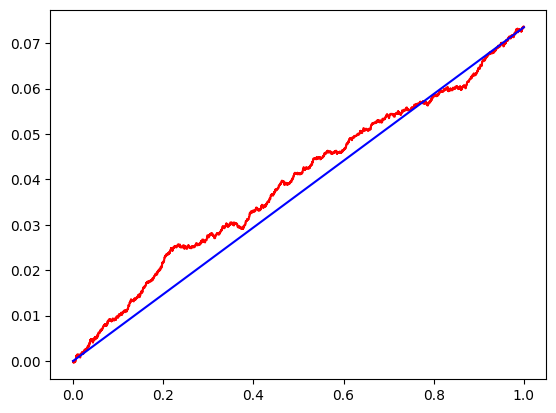

33.188959999999994


In [2]:
print(qini_df(df))

In [4]:
df

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12779,5,104.04,1,0,1,0,0,0,1,0,1,0,0.443421,0.063945,0.450813,0.041821,-0.082280,0
12780,3,558.27,1,0,1,1,0,1,0,0,0,1,0.689539,0.027868,0.224104,0.058488,0.336249,2
12781,11,211.30,1,0,0,0,1,0,0,0,0,1,0.421402,0.076274,0.396279,0.106045,0.115697,0
12782,7,335.62,1,0,1,0,0,1,0,0,0,1,0.531513,0.019835,0.381351,0.067301,0.228063,0


In [5]:
df["target_class"].unique()

array([0, 2, 3, 1])

In [15]:
df["old_target"] = 1

df.loc[df["target_class"].isin([0, 2]), "old_target"] = 0

feature_cols = [
    "recency",
    "history",
    "used_discount",
    "used_bogo",
    "is_referral",
    "zip_code_Rural",
    "zip_code_Surburban",
    "zip_code_Urban",
    "channel_Multichannel",
    "channel_Phone",
    "channel_Web",
]
target_col = "old_target"
treatment_col = "treatment"

In [10]:
df.loc[df["old_target"] == 1]["old_target"].count()

np.int64(1878)

In [16]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [17]:
from sklearn.linear_model import LogisticRegression

s_learner = LogisticRegression(
    random_state=1
)  # создайте логистическую регрессию с random_state=1
s_learner.fit(X=df_train[feature_cols + [treatment_col]], y=df_train[target_col])

# посчитайте intercept
print(s_learner.intercept_)

[-1.37359115]


In [18]:
# предскажем вероятность покупки, если скидка есть
df_test[treatment_col] = 1
df_test["yes_treatment"] = s_learner.predict_proba(
    df_test[feature_cols + [treatment_col]]
)[:, 1]

# предскажите вероятность покупки, если скидки нет
df_test[treatment_col] = 0
df_test["no_treatment"] = s_learner.predict_proba(
    df_test[feature_cols + [treatment_col]]
)[:, 1]

uplift_vals = df_test["yes_treatment"] - df_test["no_treatment"]
df_test["uplift_score"] = uplift_vals
# посчитаем Qini Score по нашему датасету

In [19]:
df_test

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,...,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target,yes_treatment,no_treatment
9948,1,186.66,0,1,1,0,1,0,0,0,...,1,0.417925,0.166987,0.279740,0.135348,0.081090,2,0,0.230118,0.149029
2002,8,508.14,1,1,1,0,0,1,0,0,...,0,0.528632,0.061418,0.308849,0.101101,0.065325,2,0,0.177732,0.112407
3045,9,286.62,0,1,1,0,0,0,1,0,...,1,0.567822,0.022656,0.348541,0.060981,0.046974,2,0,0.122736,0.075762
2124,3,161.65,0,1,0,0,0,1,0,0,...,1,0.492126,0.067740,0.360607,0.079527,0.085582,2,0,0.246229,0.160647
11454,8,81.51,1,0,0,0,0,1,0,0,...,1,0.611816,0.037360,0.292139,0.058686,0.072915,2,0,0.202238,0.129323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11109,10,218.36,0,1,0,0,0,0,1,0,...,1,0.436048,0.061912,0.429983,0.072057,0.067647,2,0,0.185104,0.117457
1113,6,693.86,1,0,1,0,0,0,1,1,...,0,0.441445,0.022622,0.506047,0.029886,0.048491,0,0,0.127091,0.078600
9726,12,29.99,0,1,1,0,0,1,0,0,...,1,0.460983,0.012075,0.465830,0.061111,0.035493,0,0,0.090724,0.055231
7467,2,380.69,0,1,0,0,0,0,1,1,...,0,0.510286,0.094385,0.288344,0.106985,0.072472,1,1,0.200774,0.128301


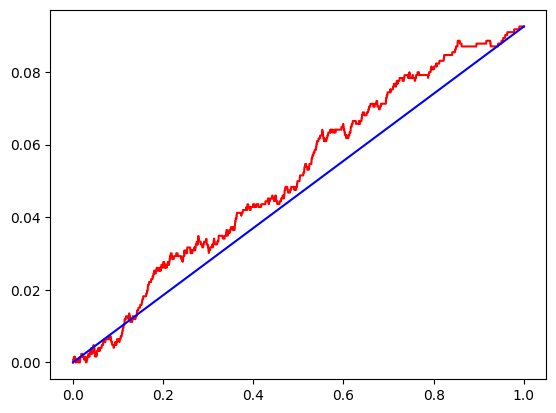

np.float64(13.196000000000002)

In [20]:
qini_df(df_test)